In [1]:
%load_ext autoreload
%autoreload 2

local_path = "/home/ios/data2"

import torch
from imageio import imread
import open3d as o3d
import numpy as np
import meshplot as mp
import matplotlib.pyplot as plt


torch.cuda.is_available()

INFO - 2021-07-30 06:32:05,772 - utils - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2021-07-30 06:32:05,773 - utils - NumExpr defaulting to 8 threads.


True

## Define PointNet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as grad

##-----------------------------------------------------------------------------
# Class for Transformer. Subclasses PyTorch's own "nn" module
#
# Computes a KxK affine transform from the input data to transform inputs
# to a "canonical view"
##
class Transformer(nn.Module):

    def __init__(self, num_points=2000, K=3):
        # Call the super constructor
        super(Transformer, self).__init__()

        # Number of dimensions of the data
        self.K = K

        # Size of input
        self.N = num_points

        # Initialize identity matrix on the GPU (do this here so it only 
        # happens once)
        self.identity = grad.Variable(
            torch.eye(self.K).double().view(-1))

        # First embedding block
        self.block1 =nn.Sequential(
            nn.Conv1d(K, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU())

        # Second embedding block
        self.block2 =nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU())

        # Third embedding block
        self.block3 =nn.Sequential(
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU())

        # Multilayer perceptron
        self.mlp = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, K * K))


    # Take as input a B x K x N matrix of B batches of N points with K 
    # dimensions
    def forward(self, x):

        # Compute the feature extractions
        # Output should ultimately be B x 1024 x N
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Pool over the number of points
        # Output should be B x 1024 x 1 --> B x 1024 (after squeeze)
        x = F.max_pool1d(x, self.N).squeeze(2)
        
        # Run the pooled features through the multi-layer perceptron
        # Output should be B x K^2
        x = self.mlp(x)

        # Add identity matrix to transform
        # Output is still B x K^2 (broadcasting takes care of batch dimension)
        self.identity = self.identity.to(x.device)
        x += self.identity

        # Reshape the output into B x K x K affine transformation matrices
        x = x.view(-1, self.K, self.K)

        return x


##-----------------------------------------------------------------------------
# Class for PointNetBase. Subclasses PyTorch's own "nn" module
#
# Computes the local embeddings and global features for an input set of points
##
class PointNetBase(nn.Module):

    def __init__(self, num_points=1024, K=3):
        # Call the super constructor
        super(PointNetBase, self).__init__()

        # Input transformer for K-dimensional input
        # K should be 3 for XYZ coordinates, but can be larger if normals, 
        # colors, etc are included
        self.input_transformer = Transformer(num_points, K)

        # Embedding transformer is always going to be 64 dimensional
        self.embedding_transformer = Transformer(num_points, 64)

        # Multilayer perceptrons with shared weights are implemented as 
        # convolutions. This is because we are mapping from K inputs to 64 
        # outputs, so we can just consider each of the 64 K-dim filters as 
        # describing the weight matrix for each point dimension (X,Y,Z,...) to
        # each index of the 64 dimension embeddings
        self.mlp1 = nn.Sequential(
            nn.Conv1d(K, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU())

        self.mlp2 = nn.Sequential(
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU())


    # Take as input a B x K x N matrix of B batches of N points with K 
    # dimensions
    def forward(self, x):

        # Number of points put into the network
        N = x.shape[2]

        # First compute the input data transform and transform the data
        # T1 is B x K x K and x is B x K x N, so output is B x K x N
        T1 = self.input_transformer(x)
        x = torch.bmm(T1, x)

        # Run the transformed inputs through the first embedding MLP
        # Output is B x 64 x N
        x = self.mlp1(x)

        # Transform the embeddings. This gives us the "local embedding" 
        # referred to in the paper/slides
        # T2 is B x 64 x 64 and x is B x 64 x N, so output is B x 64 x N
        T2 = self.embedding_transformer(x)
        local_embedding = torch.bmm(T2, x)

        # Further embed the "local embeddings"
        # Output is B x 1024 x N
        global_feature = self.mlp2(local_embedding)

        # Pool over the number of points. This results in the "global feature"
        # referred to in the paper/slides
        # Output should be B x 1024 x 1 --> B x 1024 (after squeeze)
        global_feature = F.max_pool1d(global_feature, N).squeeze(2)

        return global_feature, local_embedding, T2
    

##-----------------------------------------------------------------------------
# Class for PointNetClassifier. Subclasses PyTorch's own "nn" module
#
# Computes the local embeddings and global features for an input set of points
##
class PointNetClassifier(nn.Module):

    def __init__(self, num_points=1024, K=3, F=64):
        # Call the super constructor
        super(PointNetClassifier, self).__init__()

        # Local and global feature extractor for PointNet
        self.base = PointNetBase(num_points, K)

        # Classifier for ShapeNet
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, F))


    # Take as input a B x K x N matrix of B batches of N points with K 
    # dimensions
    def forward(self, x):

        # Only need to keep the global feature descriptors for classification
        # Output should be B x 1024
        x, _, T2 = self.base(x)

        # Returns a B x 40 
        d =  self.classifier(x)
        
        # Returns L2-Normalized descriptors
        return d / torch.norm(d, dim=1, keepdim=True)

## Define ConvNet

In [3]:
import torchvision.models as models

class ConvNet(nn.Module):
    
    
    def __init__(self, F=64):
        super().__init__()
        
        model = models.vgg16(pretrained=True)  #False

        self.features = model.features
        for param in self.features.parameters():
            param.requires_grad = True
        
        self.pool = nn.AvgPool2d(4)
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, F))

    def forward(self, X):
        
        vgg = self.features(X)
        vgg = self.pool(vgg).squeeze()
        d = self.classifier(vgg)        
        return d / torch.norm(d, dim=1, keepdim=True)
        

# Define Triplet Loss

In [4]:
class Matcher(nn.Module):

    def __init__(self, dual_gpu=False):
        super().__init__()
        
        self.volume_network = PointNetClassifier(F=40)
        self.patch_network = ConvNet(F=40)
        
        if dual_gpu:
            self.patch_network.to("cuda:0")
            self.volume_network.to("cuda:1")
            
    def forward(self, im, pc):
        return self.patch_network(im), self.volume_network(pc)



class WeightedTripletLoss(nn.Module):
    
    def __init__(self, alpha=0.4, agg="mean"):
        super().__init__()
        
        self.alpha = alpha
        if agg == "mean":
            self.mean = True
        else:
            self.mean = False
    
    def forward(self, batch):
        """
        Pairs are concatenated batches
        batch = [anchors, pairs]
        """
        idx_anchors = np.arange(0, len(batch)//4)
        idx_pairs = np.arange(len(batch)//2, 3*len(batch)//4)
        idx_neg   = np.arange(3*len(batch)//4, len(batch))
        
        anchors = batch[idx_anchors]
        
        pos_pairs   = batch[idx_pairs]
        pos_d = torch.norm(anchors - pos_pairs, dim=1)
        
        #idx_neg = np.random.permutation(idx_pairs)
        #while (idx_pairs == idx_neg).sum() > 0:
        #    idx_neg = np.random.permutation(idx_pairs)
    
        neg_pairs = batch[idx_neg]
        neg_d = torch.norm(anchors - neg_pairs, dim=1)
        
        d = pos_d - neg_d
        
        loss = torch.log(1+torch.exp(self.alpha*d))
                
        if self.mean:
            return loss.mean()
        else:
            return loss.sum()
        

# Oxford Dataset

In [ ]:
from OxfordMatchDataset import OxfordMatchDataset

OxfordMatchDataset(local_path).__download__()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.147224…

(3, 217, 217) (339, 3)


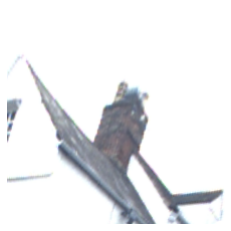

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.147224…

(3, 193, 193) (339, 3)


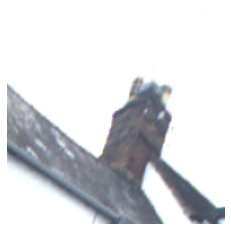

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.147224…

(3, 217, 217) (339, 3)


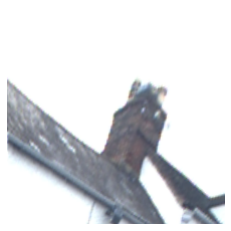

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.147224…

(3, 163, 163) (339, 3)


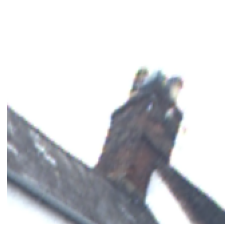

True

In [20]:

base_iss = local_path + "/3d-data/oxford/iss_zip/iss_volume/"
base_sift = local_path + "/3d-data/oxford/sift_zip/"

def read_pair(fname="2014-12-12-10-45-15/002/cam1_0085_0010_00005"):
    im = imread(base_sift + fname + ".png").transpose(2,0,1) / 255.
    pcd = o3d.io.read_point_cloud(base_iss + fname + ".pcd")
    pc = np.asarray(pcd.points)
    return im, pc

def show_pair(pair):
    im, pc = pair
    mp.plot(pc, c=pc[:, 1], shading={"point_size": 0.3, "width": 300, "height": 300})
    print(im.shape, pc.shape)
    plt.imshow(im.transpose(1,2,0))
    plt.axis("off")
    plt.show()
 
show_pair(read_pair("2014-12-12-10-45-15/002/cam1_0085_0010_00005"))
show_pair(read_pair("2014-12-12-10-45-15/002/cam1_0085_0019_00006"))
show_pair(read_pair("2014-12-12-10-45-15/002/cam1_0085_0020_00007"))
show_pair(read_pair("2014-12-12-10-45-15/002/cam1_0085_0021_00008"))

a = read_pair("2014-12-12-10-45-15/002/cam1_0085_0010_00005")[1]
b = read_pair("2014-12-12-10-45-15/002/cam1_0085_0019_00006")[1]
np.allclose(a, b)

In [7]:
segments = os.listdir(local_path + "/3d-data/oxford/iss_zip/iss_volume/")

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1955084…

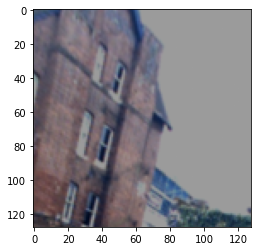

MatchDataset(path=/home/ios/data2, segments=['2015-03-17-11-08-44', '2015-05-19-14-06-38', '2014-12-05-11-09-10', '2014-06-26-09-53-12', '2015-07-08-13-37-17', '2015-04-17-09-06-25', '2015-07-14-16-17-39', '2014-12-02-15-30-08', '2015-02-17-14-42-12', '2015-03-03-11-31-36', '2015-07-14-15-16-39', '2015-06-26-08-09-43', '2014-11-25-09-18-32', '2015-08-13-16-02-58', '2015-02-03-08-45-10', '2015-07-03-15-23-28', '2014-11-28-12-07-13', '2014-07-14-15-42-55', '2014-07-14-15-16-36'], train=False, train_split=0.9)[22077]

In [8]:
ds = MatchDataset(segments=segments[:len(segments)//2], train=True)
ds_val = MatchDataset(segments=segments[:len(segments)//2], train=False)
ds.show_pair(3)
ds_val

In [27]:
from sklearn.neighbors import NearestNeighbors
from  sklearn.metrics import pairwise_distances


def recall(feat_im, feat_pc, k=3):
    N = len(feat_pc)
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(feat_im)
    idx_neighbors = nn.kneighbors(feat_pc)[1]
    ground_truth = np.repeat(np.arange(len(feat_pc)), k).reshape(-1, k)
    recall = (idx_neighbors == ground_truth).sum() / N
    return recall

def fpr(feat_im, feat_pc, recall_tresh=0.95):
    N = len(feat_pc)
    Np = int(N * recall_tresh)
    D = pairwise_distances(feat_im, feat_pc, metric='euclidean')
    threshold = np.percentile(np.diag(D), int(recall_tresh*100))
    D = D < threshold
    fpr = (D.sum() - Np)/N**2 #subtract TPs
    return fpr

In [33]:
epochs = 100
bs = 20
num_eval_batches = 3
eval_batch_size = 50
k = 5

training_data = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=bs)
validation_data = torch.utils.data.DataLoader(ds_val, shuffle=True, batch_size=eval_batch_size)
training_data_eval = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=eval_batch_size)

net = Matcher(dual_gpu=True)

optim = torch.optim.Adam(net.parameters(), lr=1e-5)
loss = WeightedTripletLoss()

In [34]:
def evaluate(data, num_eval_batches=num_eval_batches):
    l = recall_ = fpr_ = 0.
    for j, (im, pc) in enumerate(data):
        if j == num_eval_batches:
            break
        im, pc = im.to("cuda:0"), pc.to("cuda:1")
        feat_im, feat_pc = net(im, pc)
        l += loss(torch.cat([feat_im.cpu(), feat_pc.cpu()]).detach())
        recall_ += recall(feat_im.cpu().detach().numpy(), feat_pc.cpu().detach().numpy(), k=k)
        fpr_ += fpr(feat_im.cpu().detach().numpy(), feat_pc.cpu().detach().numpy())
    return l / num_eval_batches, recall_ / num_eval_batches, fpr_ / num_eval_batches

for ep in range(epochs):

    for i, (im, pc) in enumerate(training_data):

        optim.zero_grad()
        
        im, pc = im.to("cuda:0"), pc.to("cuda:1")
        
        feat_im, feat_pc = net(im, pc)
        l = loss(torch.cat([feat_im.cpu(), feat_pc.cpu()]))
        l.backward()
        
        optim.step()

        if i % 1000 == 1:
            
            l_train, recall_train, fpr_train = evaluate(training_data_eval)
            l_valid, recall_valid, fpr_valid = evaluate(validation_data)
            
            print(f"ep={ep}, mbs={i}, loss=({l_train:.3f}, {l_valid:.3f}), recall(k={k})=({recall_train:.3f}, {recall_valid:.3f}), fpr@95=({fpr_train:.3f}, {fpr_valid:.3f})")


ep=0, mbs=1, loss=(0.692, 0.691), recall(k=5)=(0.093, 0.087), fpr@95=(0.937, 0.908)
ep=0, mbs=1001, loss=(0.692, 0.693), recall(k=5)=(0.093, 0.093), fpr@95=(0.933, 0.916)
ep=0, mbs=2001, loss=(0.696, 0.683), recall(k=5)=(0.107, 0.147), fpr@95=(0.933, 0.887)
ep=0, mbs=3001, loss=(0.689, 0.695), recall(k=5)=(0.113, 0.087), fpr@95=(0.926, 0.881)
ep=0, mbs=4001, loss=(0.686, 0.688), recall(k=5)=(0.140, 0.153), fpr@95=(0.916, 0.884)
ep=0, mbs=5001, loss=(0.678, 0.689), recall(k=5)=(0.173, 0.153), fpr@95=(0.850, 0.895)
ep=0, mbs=6001, loss=(0.672, 0.674), recall(k=5)=(0.173, 0.113), fpr@95=(0.893, 0.833)
ep=0, mbs=7001, loss=(0.681, 0.674), recall(k=5)=(0.180, 0.160), fpr@95=(0.841, 0.860)
ep=0, mbs=8001, loss=(0.691, 0.682), recall(k=5)=(0.167, 0.147), fpr@95=(0.842, 0.796)
ep=0, mbs=9001, loss=(0.680, 0.682), recall(k=5)=(0.120, 0.147), fpr@95=(0.864, 0.876)
ep=1, mbs=1, loss=(0.675, 0.660), recall(k=5)=(0.180, 0.173), fpr@95=(0.775, 0.782)
ep=1, mbs=1001, loss=(0.639, 0.681), recall(k=5)=

ep=9, mbs=5001, loss=(0.603, 0.596), recall(k=5)=(0.307, 0.267), fpr@95=(0.581, 0.603)
ep=9, mbs=6001, loss=(0.580, 0.597), recall(k=5)=(0.327, 0.260), fpr@95=(0.561, 0.604)
ep=9, mbs=7001, loss=(0.570, 0.613), recall(k=5)=(0.313, 0.280), fpr@95=(0.504, 0.567)
ep=9, mbs=8001, loss=(0.596, 0.652), recall(k=5)=(0.300, 0.227), fpr@95=(0.577, 0.689)
ep=9, mbs=9001, loss=(0.608, 0.578), recall(k=5)=(0.300, 0.347), fpr@95=(0.538, 0.546)
ep=10, mbs=1, loss=(0.602, 0.615), recall(k=5)=(0.300, 0.300), fpr@95=(0.602, 0.737)
ep=10, mbs=1001, loss=(0.573, 0.599), recall(k=5)=(0.333, 0.287), fpr@95=(0.591, 0.655)
ep=10, mbs=2001, loss=(0.602, 0.638), recall(k=5)=(0.293, 0.247), fpr@95=(0.627, 0.704)
ep=10, mbs=3001, loss=(0.573, 0.590), recall(k=5)=(0.313, 0.240), fpr@95=(0.522, 0.577)
ep=10, mbs=4001, loss=(0.579, 0.579), recall(k=5)=(0.333, 0.267), fpr@95=(0.617, 0.562)
ep=10, mbs=5001, loss=(0.613, 0.623), recall(k=5)=(0.340, 0.280), fpr@95=(0.660, 0.651)
ep=10, mbs=6001, loss=(0.547, 0.590), re

ep=18, mbs=9001, loss=(0.564, 0.577), recall(k=5)=(0.413, 0.367), fpr@95=(0.472, 0.643)
ep=19, mbs=1, loss=(0.547, 0.610), recall(k=5)=(0.320, 0.287), fpr@95=(0.619, 0.775)
ep=19, mbs=1001, loss=(0.527, 0.585), recall(k=5)=(0.387, 0.353), fpr@95=(0.424, 0.718)
ep=19, mbs=2001, loss=(0.558, 0.566), recall(k=5)=(0.360, 0.313), fpr@95=(0.600, 0.776)
ep=19, mbs=3001, loss=(0.534, 0.573), recall(k=5)=(0.427, 0.347), fpr@95=(0.481, 0.825)
ep=19, mbs=4001, loss=(0.571, 0.587), recall(k=5)=(0.400, 0.400), fpr@95=(0.594, 0.707)
ep=19, mbs=5001, loss=(0.583, 0.561), recall(k=5)=(0.333, 0.407), fpr@95=(0.586, 0.680)
ep=19, mbs=6001, loss=(0.561, 0.591), recall(k=5)=(0.333, 0.353), fpr@95=(0.638, 0.756)
ep=19, mbs=7001, loss=(0.554, 0.578), recall(k=5)=(0.373, 0.333), fpr@95=(0.518, 0.610)
ep=19, mbs=8001, loss=(0.558, 0.587), recall(k=5)=(0.440, 0.280), fpr@95=(0.517, 0.740)
ep=19, mbs=9001, loss=(0.540, 0.588), recall(k=5)=(0.420, 0.347), fpr@95=(0.494, 0.721)
ep=20, mbs=1, loss=(0.544, 0.577), 

ep=28, mbs=3001, loss=(0.547, 0.563), recall(k=5)=(0.420, 0.327), fpr@95=(0.510, 0.656)
ep=28, mbs=4001, loss=(0.531, 0.551), recall(k=5)=(0.473, 0.333), fpr@95=(0.511, 0.622)
ep=28, mbs=5001, loss=(0.525, 0.555), recall(k=5)=(0.400, 0.387), fpr@95=(0.490, 0.663)
ep=28, mbs=6001, loss=(0.559, 0.575), recall(k=5)=(0.413, 0.327), fpr@95=(0.583, 0.642)
ep=28, mbs=7001, loss=(0.528, 0.586), recall(k=5)=(0.460, 0.327), fpr@95=(0.476, 0.616)
ep=28, mbs=9001, loss=(0.564, 0.553), recall(k=5)=(0.467, 0.333), fpr@95=(0.670, 0.731)
ep=29, mbs=1, loss=(0.539, 0.580), recall(k=5)=(0.433, 0.367), fpr@95=(0.476, 0.625)
ep=29, mbs=1001, loss=(0.533, 0.594), recall(k=5)=(0.393, 0.320), fpr@95=(0.480, 0.715)
ep=29, mbs=2001, loss=(0.544, 0.595), recall(k=5)=(0.433, 0.367), fpr@95=(0.423, 0.593)
ep=29, mbs=3001, loss=(0.553, 0.541), recall(k=5)=(0.400, 0.353), fpr@95=(0.536, 0.733)
ep=29, mbs=4001, loss=(0.516, 0.571), recall(k=5)=(0.460, 0.380), fpr@95=(0.495, 0.581)
ep=29, mbs=5001, loss=(0.514, 0.607

ep=37, mbs=8001, loss=(0.563, 0.585), recall(k=5)=(0.440, 0.287), fpr@95=(0.704, 0.815)
ep=37, mbs=9001, loss=(0.572, 0.598), recall(k=5)=(0.420, 0.327), fpr@95=(0.683, 0.731)
ep=38, mbs=1, loss=(0.555, 0.609), recall(k=5)=(0.427, 0.360), fpr@95=(0.654, 0.774)
ep=38, mbs=1001, loss=(0.574, 0.543), recall(k=5)=(0.413, 0.400), fpr@95=(0.654, 0.747)
ep=38, mbs=2001, loss=(0.536, 0.587), recall(k=5)=(0.500, 0.367), fpr@95=(0.399, 0.716)
ep=38, mbs=3001, loss=(0.544, 0.576), recall(k=5)=(0.440, 0.380), fpr@95=(0.535, 0.715)
ep=38, mbs=4001, loss=(0.547, 0.557), recall(k=5)=(0.480, 0.373), fpr@95=(0.474, 0.718)
ep=38, mbs=5001, loss=(0.558, 0.590), recall(k=5)=(0.413, 0.353), fpr@95=(0.665, 0.775)
ep=38, mbs=6001, loss=(0.544, 0.568), recall(k=5)=(0.413, 0.373), fpr@95=(0.491, 0.797)
ep=38, mbs=7001, loss=(0.532, 0.599), recall(k=5)=(0.460, 0.313), fpr@95=(0.363, 0.754)
ep=38, mbs=8001, loss=(0.536, 0.548), recall(k=5)=(0.480, 0.320), fpr@95=(0.520, 0.758)
ep=38, mbs=9001, loss=(0.543, 0.585

ep=47, mbs=2001, loss=(0.543, 0.581), recall(k=5)=(0.420, 0.373), fpr@95=(0.472, 0.785)
ep=47, mbs=3001, loss=(0.500, 0.586), recall(k=5)=(0.467, 0.327), fpr@95=(0.429, 0.661)
ep=47, mbs=4001, loss=(0.541, 0.590), recall(k=5)=(0.440, 0.373), fpr@95=(0.667, 0.661)
ep=47, mbs=5001, loss=(0.533, 0.621), recall(k=5)=(0.433, 0.327), fpr@95=(0.482, 0.732)
ep=47, mbs=6001, loss=(0.565, 0.617), recall(k=5)=(0.413, 0.340), fpr@95=(0.496, 0.720)
ep=47, mbs=7001, loss=(0.552, 0.536), recall(k=5)=(0.407, 0.393), fpr@95=(0.483, 0.741)
ep=47, mbs=8001, loss=(0.577, 0.610), recall(k=5)=(0.440, 0.367), fpr@95=(0.596, 0.724)
ep=47, mbs=9001, loss=(0.524, 0.609), recall(k=5)=(0.420, 0.347), fpr@95=(0.432, 0.799)
ep=48, mbs=1, loss=(0.562, 0.584), recall(k=5)=(0.380, 0.380), fpr@95=(0.533, 0.680)
ep=48, mbs=1001, loss=(0.520, 0.599), recall(k=5)=(0.453, 0.327), fpr@95=(0.365, 0.772)
ep=48, mbs=2001, loss=(0.542, 0.570), recall(k=5)=(0.433, 0.340), fpr@95=(0.753, 0.745)
ep=48, mbs=3001, loss=(0.528, 0.600

ep=56, mbs=6001, loss=(0.521, 0.557), recall(k=5)=(0.413, 0.407), fpr@95=(0.560, 0.635)
ep=56, mbs=7001, loss=(0.520, 0.591), recall(k=5)=(0.420, 0.367), fpr@95=(0.494, 0.749)
ep=56, mbs=8001, loss=(0.533, 0.578), recall(k=5)=(0.453, 0.320), fpr@95=(0.392, 0.791)
ep=56, mbs=9001, loss=(0.537, 0.598), recall(k=5)=(0.440, 0.360), fpr@95=(0.455, 0.758)
ep=57, mbs=1, loss=(0.540, 0.614), recall(k=5)=(0.387, 0.373), fpr@95=(0.525, 0.780)
ep=57, mbs=1001, loss=(0.555, 0.577), recall(k=5)=(0.480, 0.293), fpr@95=(0.414, 0.736)
ep=57, mbs=2001, loss=(0.536, 0.575), recall(k=5)=(0.433, 0.287), fpr@95=(0.421, 0.674)
ep=57, mbs=3001, loss=(0.575, 0.569), recall(k=5)=(0.447, 0.353), fpr@95=(0.553, 0.727)
ep=57, mbs=4001, loss=(0.511, 0.573), recall(k=5)=(0.407, 0.380), fpr@95=(0.397, 0.723)
ep=57, mbs=5001, loss=(0.526, 0.588), recall(k=5)=(0.460, 0.307), fpr@95=(0.524, 0.761)
ep=57, mbs=6001, loss=(0.533, 0.591), recall(k=5)=(0.507, 0.273), fpr@95=(0.555, 0.836)
ep=57, mbs=7001, loss=(0.536, 0.561

ep=66, mbs=1, loss=(0.545, 0.586), recall(k=5)=(0.460, 0.340), fpr@95=(0.465, 0.764)
ep=66, mbs=1001, loss=(0.552, 0.605), recall(k=5)=(0.433, 0.360), fpr@95=(0.422, 0.797)
ep=66, mbs=2001, loss=(0.529, 0.582), recall(k=5)=(0.413, 0.293), fpr@95=(0.360, 0.745)
ep=66, mbs=3001, loss=(0.504, 0.580), recall(k=5)=(0.527, 0.293), fpr@95=(0.332, 0.783)
ep=66, mbs=4001, loss=(0.531, 0.580), recall(k=5)=(0.400, 0.340), fpr@95=(0.409, 0.652)
ep=66, mbs=5001, loss=(0.556, 0.589), recall(k=5)=(0.433, 0.313), fpr@95=(0.417, 0.833)
ep=66, mbs=6001, loss=(0.532, 0.568), recall(k=5)=(0.367, 0.373), fpr@95=(0.452, 0.686)
ep=66, mbs=7001, loss=(0.559, 0.602), recall(k=5)=(0.420, 0.353), fpr@95=(0.554, 0.833)
ep=66, mbs=8001, loss=(0.520, 0.579), recall(k=5)=(0.507, 0.327), fpr@95=(0.438, 0.740)
ep=66, mbs=9001, loss=(0.518, 0.574), recall(k=5)=(0.473, 0.400), fpr@95=(0.533, 0.747)
ep=67, mbs=1, loss=(0.530, 0.576), recall(k=5)=(0.473, 0.353), fpr@95=(0.375, 0.727)
ep=67, mbs=1001, loss=(0.556, 0.608), 

ep=75, mbs=4001, loss=(0.516, 0.575), recall(k=5)=(0.407, 0.333), fpr@95=(0.293, 0.786)
ep=75, mbs=5001, loss=(0.519, 0.567), recall(k=5)=(0.467, 0.367), fpr@95=(0.417, 0.583)
ep=75, mbs=6001, loss=(0.542, 0.591), recall(k=5)=(0.467, 0.313), fpr@95=(0.496, 0.711)
ep=75, mbs=7001, loss=(0.548, 0.590), recall(k=5)=(0.400, 0.367), fpr@95=(0.579, 0.769)
ep=75, mbs=8001, loss=(0.537, 0.577), recall(k=5)=(0.400, 0.373), fpr@95=(0.578, 0.798)
ep=75, mbs=9001, loss=(0.546, 0.571), recall(k=5)=(0.413, 0.393), fpr@95=(0.451, 0.783)
ep=76, mbs=1, loss=(0.522, 0.572), recall(k=5)=(0.393, 0.307), fpr@95=(0.446, 0.707)
ep=76, mbs=1001, loss=(0.543, 0.567), recall(k=5)=(0.433, 0.347), fpr@95=(0.295, 0.764)
ep=76, mbs=2001, loss=(0.528, 0.592), recall(k=5)=(0.507, 0.287), fpr@95=(0.425, 0.857)
ep=76, mbs=3001, loss=(0.527, 0.558), recall(k=5)=(0.507, 0.373), fpr@95=(0.456, 0.735)
ep=76, mbs=4001, loss=(0.516, 0.635), recall(k=5)=(0.447, 0.287), fpr@95=(0.478, 0.809)
ep=76, mbs=5001, loss=(0.557, 0.581

ep=84, mbs=8001, loss=(0.550, 0.571), recall(k=5)=(0.380, 0.280), fpr@95=(0.573, 0.772)
ep=84, mbs=9001, loss=(0.534, 0.579), recall(k=5)=(0.407, 0.380), fpr@95=(0.358, 0.788)
ep=85, mbs=1, loss=(0.536, 0.577), recall(k=5)=(0.460, 0.367), fpr@95=(0.458, 0.692)
ep=85, mbs=1001, loss=(0.490, 0.606), recall(k=5)=(0.447, 0.347), fpr@95=(0.522, 0.766)
ep=85, mbs=2001, loss=(0.544, 0.571), recall(k=5)=(0.367, 0.373), fpr@95=(0.363, 0.752)
ep=85, mbs=3001, loss=(0.508, 0.576), recall(k=5)=(0.433, 0.353), fpr@95=(0.434, 0.724)
ep=85, mbs=4001, loss=(0.535, 0.575), recall(k=5)=(0.440, 0.380), fpr@95=(0.574, 0.749)
ep=85, mbs=5001, loss=(0.535, 0.602), recall(k=5)=(0.453, 0.373), fpr@95=(0.547, 0.763)
ep=85, mbs=6001, loss=(0.504, 0.580), recall(k=5)=(0.393, 0.333), fpr@95=(0.372, 0.689)
ep=85, mbs=7001, loss=(0.532, 0.561), recall(k=5)=(0.440, 0.327), fpr@95=(0.484, 0.781)
ep=85, mbs=8001, loss=(0.535, 0.611), recall(k=5)=(0.407, 0.393), fpr@95=(0.387, 0.774)
ep=85, mbs=9001, loss=(0.519, 0.612

ep=94, mbs=2001, loss=(0.500, 0.588), recall(k=5)=(0.460, 0.367), fpr@95=(0.297, 0.737)
ep=94, mbs=3001, loss=(0.529, 0.568), recall(k=5)=(0.387, 0.347), fpr@95=(0.280, 0.724)
ep=94, mbs=4001, loss=(0.517, 0.602), recall(k=5)=(0.393, 0.347), fpr@95=(0.450, 0.763)
ep=94, mbs=5001, loss=(0.527, 0.578), recall(k=5)=(0.373, 0.360), fpr@95=(0.468, 0.722)
ep=94, mbs=6001, loss=(0.552, 0.604), recall(k=5)=(0.367, 0.273), fpr@95=(0.650, 0.741)
ep=94, mbs=7001, loss=(0.531, 0.620), recall(k=5)=(0.433, 0.313), fpr@95=(0.434, 0.737)
ep=94, mbs=8001, loss=(0.555, 0.550), recall(k=5)=(0.460, 0.293), fpr@95=(0.495, 0.744)
ep=94, mbs=9001, loss=(0.552, 0.599), recall(k=5)=(0.447, 0.367), fpr@95=(0.357, 0.689)
ep=95, mbs=1, loss=(0.556, 0.588), recall(k=5)=(0.467, 0.300), fpr@95=(0.618, 0.801)
ep=95, mbs=1001, loss=(0.522, 0.571), recall(k=5)=(0.427, 0.313), fpr@95=(0.432, 0.788)
ep=95, mbs=2001, loss=(0.539, 0.572), recall(k=5)=(0.447, 0.387), fpr@95=(0.339, 0.781)
ep=95, mbs=3001, loss=(0.528, 0.587

# PyKitti Dataset

In [5]:
from PyKitti2Dataset import *
from PyKittiPatches import *


basedir = '/home/ios/data3/kitti/tracking/training'
basedir_testing = '/home/ios/data3/kitti/tracking/testing/'
sequence = '0000'



ds = PyKittiPatches(basedir, train=True, val_split=0.9, sequences=[f"00{i:02d}" for i in range(20)])
ds_val = PyKittiPatches(basedir, train=False, val_split=0.9, sequences=[f"00{i:02d}" for i in range(20)])
ds, ds_val

(PyKittiPatches(base_path=/home/ios/data3/kitti/tracking/training, train=True, val_split=0.9, sequences=['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019'])[37536],
 PyKittiPatches(base_path=/home/ios/data3/kitti/tracking/training, train=False, val_split=0.9, sequences=['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019'])[3753])

In [6]:
ds[0][0].shape, ds[0][1].shape

(torch.Size([3, 128, 128]), torch.Size([3, 1024]))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.005147…

WARNING - 2021-07-26 14:19:27,213 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3) (1024, 3)


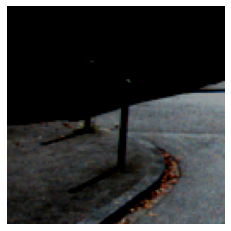

In [144]:
ds.show_pair(60)

In [7]:
from sklearn.neighbors import NearestNeighbors
from  sklearn.metrics import pairwise_distances


def recall(feat_im, feat_pc, k=3):
    N = len(feat_pc)
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(feat_im)
    idx_neighbors = nn.kneighbors(feat_pc)[1]
    ground_truth = np.repeat(np.arange(len(feat_pc)), k).reshape(-1, k)
    recall = (idx_neighbors == ground_truth).sum() / N
    return recall

def fpr(feat_im, feat_pc, recall_tresh=0.95):
    N = len(feat_pc)
    Np = int(N * recall_tresh)
    D = pairwise_distances(feat_im, feat_pc, metric='euclidean')
    threshold = np.percentile(np.diag(D), int(recall_tresh*100))
    D = D < threshold
    fpr = (D.sum() - Np)/N**2 #subtract TPs
    return fpr

In [8]:
class WeightedTripletLoss(nn.Module):
    
    def __init__(self, alpha=0.4, agg="mean"):
        super().__init__()
        
        self.alpha = alpha
        if agg == "mean":
            self.mean = True
        else:
            self.mean = False
    
    def forward(self, batch, seq, step):
        """
        Pairs are concatenated batches
        batch = [anchors, pairs]
        seqstep = (seq, step)
        """
        seq = torch.cat([seq, seq])
        step = torch.cat([step, step])
        #print("step", step)
        
        idx_anchors = np.arange(0, len(batch)//4)
        idx_pairs = np.arange(len(batch)//2, 3*len(batch)//4)
        idx_neg   = np.arange(3*len(batch)//4, len(batch))
        
        anchors = batch[idx_anchors]
        anchors_steps = step[idx_anchors]
        
        pos_pairs   = batch[idx_pairs]
        pos_steps = step[idx_pairs]
        pos_d = torch.norm(anchors - pos_pairs, dim=1)
        
        #idx_neg = np.random.permutation(idx_pairs)
        #while (idx_pairs == idx_neg).sum() > 0:
        #    idx_neg = np.random.permutation(idx_pairs)
    
        neg_pairs = batch[idx_neg]
        neg_steps = step[idx_neg]
        neg_d = torch.norm(anchors - neg_pairs, dim=1)
        
        d = pos_d - neg_d
        
        # Filter out triplets that are not of the same seq
        #d[anchors_steps != neg_steps] *= 0
        #print("eval", anchors_steps != neg_steps)
        #print("debug", anchors_steps, neg_steps)
        
        loss = torch.log(1+torch.exp(self.alpha*d))
                
        if self.mean:
            return loss.mean()
        else:
            return loss.sum()
        

In [9]:
class My_sampler():

    def __init__(self, ds, batch_size):
        
        self.ds = ds
        self.batch_size = batch_size
        
        self.idx = np.arange(0, len(self.ds), batch_size)
        np.random.shuffle(self.idx)
        
        
    def __getitem__(self,index):
        if index < len(self.idx):
            return np.arange(self.idx[index], self.idx[index] + self.batch_size).astype(np.int8)
        else:
            raise IndexError('this is high enough')
            np.random.shuffle(self.idx)
    

In [10]:
bs = 20
num_eval_batches = 3
eval_batch_size = 40

In [ ]:
training_data = torch.utils.data.DataLoader(ds, batch_sampler=My_sampler(ds, bs))
validation_data = torch.utils.data.DataLoader(ds_val, batch_sampler=My_sampler(ds_val, eval_batch_size))
training_data_eval = torch.utils.data.DataLoader(ds, batch_sampler=My_sampler(ds, eval_batch_size))

In [11]:
training_data = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=True)
validation_data = torch.utils.data.DataLoader(ds_val, batch_size=eval_batch_size, shuffle=True)
training_data_eval = torch.utils.data.DataLoader(ds, batch_size=eval_batch_size, shuffle=True)

In [12]:
epochs = 100
k = 5


net = Matcher(dual_gpu=True)

optim = torch.optim.Adam(net.parameters(), lr=1e-5)
loss = WeightedTripletLoss()

In [13]:
def evaluate(data, num_eval_batches=num_eval_batches):
    l = recall_ = fpr_ = 0.
    for j, (im, pc, seq, step, frame, pos) in enumerate(data):
        if j == num_eval_batches:
            break
        im, pc = im.to("cuda:0"), pc.to("cuda:1")
        feat_im, feat_pc = net(im, pc)
        l += loss(torch.cat([feat_im.cpu(), feat_pc.cpu()]).detach(), seq, step)
        recall_ += recall(feat_im.cpu().detach().numpy(), feat_pc.cpu().detach().numpy(), k=k)
        fpr_ += fpr(feat_im.cpu().detach().numpy(), feat_pc.cpu().detach().numpy())
    return l / num_eval_batches, recall_ / num_eval_batches, fpr_ / num_eval_batches

for ep in range(epochs):

    for i, (im, pc, seq, step, frame, pos) in enumerate(training_data):

        optim.zero_grad()
        
        im, pc = im.to("cuda:0"), pc.to("cuda:1")
        
        feat_im, feat_pc = net(im, pc)
        l = loss(torch.cat([feat_im.cpu(), feat_pc.cpu()]), seq, step)
        l.backward()
        
        optim.step()

        if i % 500 == 1:
            
            l_train, recall_train, fpr_train = evaluate(training_data_eval)
            l_valid, recall_valid, fpr_valid = evaluate(validation_data)
            
            print(f"ep={ep}, mbs={i}, loss=({l_train:.3f}, {l_valid:.3f}), recall(k={k})=({recall_train:.3f}, {recall_valid:.3f}), fpr@95=({fpr_train:.3f}, {fpr_valid:.3f})")


ep=0, mbs=1, loss=(0.690, 0.697), recall(k=5)=(0.233, 0.142), fpr@95=(0.926, 0.912)
ep=0, mbs=501, loss=(0.695, 0.697), recall(k=5)=(0.108, 0.142), fpr@95=(0.884, 0.918)
ep=0, mbs=1001, loss=(0.690, 0.688), recall(k=5)=(0.192, 0.150), fpr@95=(0.885, 0.881)
ep=0, mbs=1501, loss=(0.696, 0.697), recall(k=5)=(0.150, 0.067), fpr@95=(0.910, 0.906)
ep=1, mbs=1, loss=(0.688, 0.693), recall(k=5)=(0.067, 0.158), fpr@95=(0.855, 0.912)
ep=1, mbs=501, loss=(0.694, 0.685), recall(k=5)=(0.158, 0.175), fpr@95=(0.914, 0.870)
ep=1, mbs=1001, loss=(0.683, 0.695), recall(k=5)=(0.158, 0.167), fpr@95=(0.866, 0.868)
ep=1, mbs=1501, loss=(0.691, 0.684), recall(k=5)=(0.192, 0.183), fpr@95=(0.864, 0.900)
ep=2, mbs=1, loss=(0.691, 0.683), recall(k=5)=(0.167, 0.150), fpr@95=(0.853, 0.806)
ep=2, mbs=501, loss=(0.685, 0.686), recall(k=5)=(0.150, 0.217), fpr@95=(0.870, 0.859)
ep=2, mbs=1001, loss=(0.679, 0.657), recall(k=5)=(0.158, 0.175), fpr@95=(0.827, 0.796)
ep=2, mbs=1501, loss=(0.661, 0.673), recall(k=5)=(0.167

ep=23, mbs=1501, loss=(0.547, 0.572), recall(k=5)=(0.400, 0.333), fpr@95=(0.484, 0.477)
ep=24, mbs=1, loss=(0.553, 0.564), recall(k=5)=(0.450, 0.358), fpr@95=(0.395, 0.449)
ep=24, mbs=501, loss=(0.536, 0.551), recall(k=5)=(0.392, 0.375), fpr@95=(0.429, 0.449)
ep=24, mbs=1001, loss=(0.549, 0.566), recall(k=5)=(0.358, 0.375), fpr@95=(0.457, 0.496)
ep=24, mbs=1501, loss=(0.561, 0.564), recall(k=5)=(0.375, 0.375), fpr@95=(0.458, 0.467)
ep=25, mbs=1, loss=(0.563, 0.537), recall(k=5)=(0.350, 0.375), fpr@95=(0.427, 0.445)
ep=25, mbs=501, loss=(0.566, 0.567), recall(k=5)=(0.433, 0.367), fpr@95=(0.453, 0.497)
ep=25, mbs=1001, loss=(0.541, 0.564), recall(k=5)=(0.325, 0.392), fpr@95=(0.441, 0.446)
ep=25, mbs=1501, loss=(0.558, 0.576), recall(k=5)=(0.392, 0.375), fpr@95=(0.462, 0.496)
ep=26, mbs=1, loss=(0.569, 0.597), recall(k=5)=(0.450, 0.417), fpr@95=(0.452, 0.551)
ep=26, mbs=501, loss=(0.562, 0.555), recall(k=5)=(0.392, 0.392), fpr@95=(0.409, 0.411)
ep=26, mbs=1001, loss=(0.557, 0.530), recall

ep=47, mbs=1001, loss=(0.520, 0.526), recall(k=5)=(0.600, 0.400), fpr@95=(0.321, 0.389)
ep=47, mbs=1501, loss=(0.510, 0.536), recall(k=5)=(0.508, 0.425), fpr@95=(0.374, 0.432)
ep=48, mbs=1, loss=(0.523, 0.529), recall(k=5)=(0.550, 0.467), fpr@95=(0.283, 0.483)
ep=48, mbs=501, loss=(0.515, 0.524), recall(k=5)=(0.525, 0.467), fpr@95=(0.333, 0.440)
ep=48, mbs=1001, loss=(0.501, 0.605), recall(k=5)=(0.492, 0.467), fpr@95=(0.357, 0.476)
ep=48, mbs=1501, loss=(0.542, 0.531), recall(k=5)=(0.533, 0.408), fpr@95=(0.369, 0.489)
ep=49, mbs=1, loss=(0.545, 0.549), recall(k=5)=(0.608, 0.433), fpr@95=(0.301, 0.430)
ep=49, mbs=501, loss=(0.510, 0.538), recall(k=5)=(0.508, 0.408), fpr@95=(0.305, 0.490)
ep=49, mbs=1001, loss=(0.536, 0.573), recall(k=5)=(0.567, 0.400), fpr@95=(0.330, 0.371)
ep=49, mbs=1501, loss=(0.536, 0.537), recall(k=5)=(0.583, 0.475), fpr@95=(0.290, 0.326)
ep=50, mbs=1, loss=(0.528, 0.539), recall(k=5)=(0.483, 0.492), fpr@95=(0.303, 0.540)
ep=50, mbs=501, loss=(0.545, 0.550), recall

ep=71, mbs=501, loss=(0.500, 0.574), recall(k=5)=(0.583, 0.467), fpr@95=(0.267, 0.400)
ep=71, mbs=1001, loss=(0.565, 0.563), recall(k=5)=(0.550, 0.417), fpr@95=(0.299, 0.523)
ep=71, mbs=1501, loss=(0.514, 0.530), recall(k=5)=(0.525, 0.425), fpr@95=(0.295, 0.425)
ep=72, mbs=1, loss=(0.512, 0.551), recall(k=5)=(0.592, 0.442), fpr@95=(0.294, 0.490)
ep=72, mbs=501, loss=(0.494, 0.530), recall(k=5)=(0.600, 0.533), fpr@95=(0.275, 0.368)
ep=72, mbs=1001, loss=(0.514, 0.554), recall(k=5)=(0.600, 0.442), fpr@95=(0.261, 0.406)
ep=72, mbs=1501, loss=(0.539, 0.548), recall(k=5)=(0.558, 0.442), fpr@95=(0.343, 0.400)
ep=73, mbs=1, loss=(0.523, 0.563), recall(k=5)=(0.525, 0.375), fpr@95=(0.305, 0.605)
ep=73, mbs=501, loss=(0.539, 0.524), recall(k=5)=(0.575, 0.483), fpr@95=(0.279, 0.395)
ep=73, mbs=1001, loss=(0.546, 0.527), recall(k=5)=(0.517, 0.483), fpr@95=(0.268, 0.316)
ep=73, mbs=1501, loss=(0.521, 0.545), recall(k=5)=(0.492, 0.500), fpr@95=(0.267, 0.372)
ep=74, mbs=1, loss=(0.545, 0.569), recall

ep=95, mbs=1, loss=(0.523, 0.543), recall(k=5)=(0.617, 0.483), fpr@95=(0.235, 0.335)
ep=95, mbs=501, loss=(0.528, 0.534), recall(k=5)=(0.583, 0.450), fpr@95=(0.245, 0.404)
ep=95, mbs=1001, loss=(0.535, 0.531), recall(k=5)=(0.567, 0.458), fpr@95=(0.285, 0.377)
ep=95, mbs=1501, loss=(0.512, 0.544), recall(k=5)=(0.642, 0.517), fpr@95=(0.285, 0.481)
ep=96, mbs=1, loss=(0.520, 0.534), recall(k=5)=(0.642, 0.500), fpr@95=(0.235, 0.350)
ep=96, mbs=501, loss=(0.510, 0.537), recall(k=5)=(0.600, 0.425), fpr@95=(0.274, 0.438)
ep=96, mbs=1001, loss=(0.517, 0.559), recall(k=5)=(0.542, 0.467), fpr@95=(0.282, 0.410)
ep=96, mbs=1501, loss=(0.548, 0.553), recall(k=5)=(0.567, 0.433), fpr@95=(0.258, 0.414)
ep=97, mbs=1, loss=(0.504, 0.575), recall(k=5)=(0.667, 0.458), fpr@95=(0.238, 0.441)
ep=97, mbs=501, loss=(0.527, 0.537), recall(k=5)=(0.567, 0.442), fpr@95=(0.258, 0.395)
ep=97, mbs=1001, loss=(0.509, 0.535), recall(k=5)=(0.600, 0.433), fpr@95=(0.268, 0.452)
ep=97, mbs=1501, loss=(0.488, 0.560), recall

In [187]:
def evaluate(data, num_eval_batches=num_eval_batches):
    l = recall_ = fpr_ = 0.
    for j, (im, pc, seq, step, frame, pos) in enumerate(data):
        if j == num_eval_batches:
            break
        im, pc = im.to("cuda:0"), pc.to("cuda:1")
        feat_im, feat_pc = net(im, pc)
        l += loss(torch.cat([feat_im.cpu(), feat_pc.cpu()]).detach(), seq, step)
        recall_ += recall(feat_im.cpu().detach().numpy(), feat_pc.cpu().detach().numpy(), k=k)
        fpr_ += fpr(feat_im.cpu().detach().numpy(), feat_pc.cpu().detach().numpy())
    return l / num_eval_batches, recall_ / num_eval_batches, fpr_ / num_eval_batches

for ep in range(epochs):

    for i, (im, pc, seq, step, frame, pos) in enumerate(training_data):

        optim.zero_grad()
        
        im, pc = im.to("cuda:0"), pc.to("cuda:1")
        
        feat_im, feat_pc = net(im, pc)
        l = loss(torch.cat([feat_im.cpu(), feat_pc.cpu()]), seq, step)
        l.backward()
        
        optim.step()

        if i % 500 == 1:
            
            l_train, recall_train, fpr_train = evaluate(training_data_eval)
            l_valid, recall_valid, fpr_valid = evaluate(validation_data)
            
            print(f"ep={ep}, mbs={i}, loss=({l_train:.3f}, {l_valid:.3f}), recall(k={k})=({recall_train:.3f}, {recall_valid:.3f}), fpr@95=({fpr_train:.3f}, {fpr_valid:.3f})")


ep=0, mbs=1, loss=(0.576, 0.552), recall(k=5)=(0.383, 0.350), fpr@95=(0.495, 0.500)
ep=0, mbs=501, loss=(0.566, 0.599), recall(k=5)=(0.325, 0.417), fpr@95=(0.658, 0.560)
ep=0, mbs=1001, loss=(0.567, 0.575), recall(k=5)=(0.400, 0.383), fpr@95=(0.500, 0.539)
ep=0, mbs=1501, loss=(0.594, 0.590), recall(k=5)=(0.367, 0.375), fpr@95=(0.579, 0.527)
ep=0, mbs=2001, loss=(0.591, 0.572), recall(k=5)=(0.358, 0.342), fpr@95=(0.542, 0.506)
ep=0, mbs=2501, loss=(0.567, 0.574), recall(k=5)=(0.350, 0.358), fpr@95=(0.519, 0.540)
ep=0, mbs=3001, loss=(0.603, 0.562), recall(k=5)=(0.433, 0.367), fpr@95=(0.597, 0.505)
ep=0, mbs=3501, loss=(0.575, 0.578), recall(k=5)=(0.408, 0.417), fpr@95=(0.583, 0.528)
ep=1, mbs=1, loss=(0.557, 0.580), recall(k=5)=(0.417, 0.383), fpr@95=(0.583, 0.512)
ep=1, mbs=501, loss=(0.563, 0.603), recall(k=5)=(0.475, 0.375), fpr@95=(0.511, 0.569)
ep=1, mbs=1001, loss=(0.565, 0.572), recall(k=5)=(0.375, 0.358), fpr@95=(0.545, 0.585)
ep=1, mbs=1501, loss=(0.576, 0.596), recall(k=5)=(0

ep=11, mbs=3501, loss=(0.552, 0.572), recall(k=5)=(0.442, 0.442), fpr@95=(0.477, 0.503)
ep=12, mbs=1, loss=(0.557, 0.515), recall(k=5)=(0.500, 0.517), fpr@95=(0.461, 0.516)
ep=12, mbs=501, loss=(0.551, 0.564), recall(k=5)=(0.442, 0.475), fpr@95=(0.465, 0.485)
ep=12, mbs=1001, loss=(0.550, 0.557), recall(k=5)=(0.500, 0.508), fpr@95=(0.399, 0.502)
ep=12, mbs=1501, loss=(0.542, 0.585), recall(k=5)=(0.475, 0.433), fpr@95=(0.448, 0.472)
ep=12, mbs=2001, loss=(0.535, 0.575), recall(k=5)=(0.575, 0.450), fpr@95=(0.404, 0.473)
ep=12, mbs=2501, loss=(0.539, 0.557), recall(k=5)=(0.533, 0.475), fpr@95=(0.431, 0.615)
ep=12, mbs=3001, loss=(0.554, 0.585), recall(k=5)=(0.508, 0.350), fpr@95=(0.461, 0.526)
ep=12, mbs=3501, loss=(0.534, 0.547), recall(k=5)=(0.517, 0.425), fpr@95=(0.396, 0.482)
ep=13, mbs=1, loss=(0.550, 0.602), recall(k=5)=(0.450, 0.417), fpr@95=(0.452, 0.506)
ep=13, mbs=501, loss=(0.552, 0.600), recall(k=5)=(0.500, 0.433), fpr@95=(0.404, 0.479)
ep=13, mbs=1001, loss=(0.574, 0.578), re

ep=23, mbs=2501, loss=(0.530, 0.525), recall(k=5)=(0.567, 0.550), fpr@95=(0.326, 0.462)
ep=23, mbs=3001, loss=(0.555, 0.550), recall(k=5)=(0.583, 0.442), fpr@95=(0.324, 0.545)
ep=23, mbs=3501, loss=(0.551, 0.550), recall(k=5)=(0.525, 0.392), fpr@95=(0.410, 0.492)
ep=24, mbs=1, loss=(0.564, 0.545), recall(k=5)=(0.558, 0.467), fpr@95=(0.393, 0.444)
ep=24, mbs=501, loss=(0.516, 0.566), recall(k=5)=(0.533, 0.525), fpr@95=(0.349, 0.486)
ep=24, mbs=1001, loss=(0.534, 0.608), recall(k=5)=(0.533, 0.450), fpr@95=(0.348, 0.510)
ep=24, mbs=1501, loss=(0.590, 0.562), recall(k=5)=(0.550, 0.492), fpr@95=(0.377, 0.629)
ep=24, mbs=2001, loss=(0.527, 0.572), recall(k=5)=(0.525, 0.475), fpr@95=(0.458, 0.589)
ep=24, mbs=2501, loss=(0.559, 0.555), recall(k=5)=(0.550, 0.558), fpr@95=(0.385, 0.486)
ep=24, mbs=3001, loss=(0.530, 0.542), recall(k=5)=(0.592, 0.542), fpr@95=(0.375, 0.427)
ep=24, mbs=3501, loss=(0.540, 0.554), recall(k=5)=(0.533, 0.442), fpr@95=(0.301, 0.534)
ep=25, mbs=1, loss=(0.539, 0.546), r

ep=35, mbs=1501, loss=(0.540, 0.548), recall(k=5)=(0.558, 0.417), fpr@95=(0.390, 0.428)
ep=35, mbs=2001, loss=(0.531, 0.575), recall(k=5)=(0.600, 0.575), fpr@95=(0.292, 0.469)
ep=35, mbs=2501, loss=(0.557, 0.571), recall(k=5)=(0.667, 0.450), fpr@95=(0.310, 0.581)
ep=35, mbs=3001, loss=(0.506, 0.547), recall(k=5)=(0.608, 0.500), fpr@95=(0.349, 0.326)
ep=35, mbs=3501, loss=(0.543, 0.574), recall(k=5)=(0.608, 0.467), fpr@95=(0.338, 0.487)
ep=36, mbs=1, loss=(0.535, 0.536), recall(k=5)=(0.608, 0.483), fpr@95=(0.293, 0.492)
ep=36, mbs=501, loss=(0.534, 0.580), recall(k=5)=(0.525, 0.508), fpr@95=(0.379, 0.378)
ep=36, mbs=1001, loss=(0.522, 0.555), recall(k=5)=(0.517, 0.550), fpr@95=(0.457, 0.536)
ep=36, mbs=1501, loss=(0.518, 0.535), recall(k=5)=(0.667, 0.508), fpr@95=(0.255, 0.376)
ep=36, mbs=2001, loss=(0.514, 0.526), recall(k=5)=(0.575, 0.517), fpr@95=(0.297, 0.455)
ep=36, mbs=2501, loss=(0.525, 0.555), recall(k=5)=(0.625, 0.508), fpr@95=(0.414, 0.509)
ep=36, mbs=3001, loss=(0.559, 0.545)

ep=47, mbs=501, loss=(0.521, 0.536), recall(k=5)=(0.633, 0.592), fpr@95=(0.290, 0.351)
ep=47, mbs=1001, loss=(0.562, 0.518), recall(k=5)=(0.550, 0.517), fpr@95=(0.292, 0.428)
ep=47, mbs=1501, loss=(0.551, 0.543), recall(k=5)=(0.583, 0.442), fpr@95=(0.387, 0.339)
ep=47, mbs=2001, loss=(0.527, 0.564), recall(k=5)=(0.692, 0.483), fpr@95=(0.267, 0.444)
ep=47, mbs=2501, loss=(0.535, 0.545), recall(k=5)=(0.575, 0.450), fpr@95=(0.286, 0.411)
ep=47, mbs=3001, loss=(0.526, 0.594), recall(k=5)=(0.617, 0.425), fpr@95=(0.304, 0.448)
ep=47, mbs=3501, loss=(0.543, 0.572), recall(k=5)=(0.600, 0.550), fpr@95=(0.230, 0.620)
ep=48, mbs=1, loss=(0.532, 0.544), recall(k=5)=(0.492, 0.492), fpr@95=(0.435, 0.427)
ep=48, mbs=501, loss=(0.514, 0.582), recall(k=5)=(0.633, 0.517), fpr@95=(0.296, 0.572)
ep=48, mbs=1001, loss=(0.536, 0.546), recall(k=5)=(0.633, 0.550), fpr@95=(0.318, 0.402)
ep=48, mbs=1501, loss=(0.522, 0.562), recall(k=5)=(0.633, 0.492), fpr@95=(0.291, 0.476)
ep=48, mbs=2001, loss=(0.508, 0.548),

ep=59, mbs=501, loss=(0.516, 0.552), recall(k=5)=(0.667, 0.458), fpr@95=(0.295, 0.474)
ep=59, mbs=1001, loss=(0.541, 0.524), recall(k=5)=(0.642, 0.558), fpr@95=(0.448, 0.393)
ep=59, mbs=1501, loss=(0.527, 0.559), recall(k=5)=(0.667, 0.458), fpr@95=(0.275, 0.420)
ep=59, mbs=2001, loss=(0.508, 0.540), recall(k=5)=(0.650, 0.592), fpr@95=(0.300, 0.339)
ep=59, mbs=2501, loss=(0.516, 0.559), recall(k=5)=(0.733, 0.467), fpr@95=(0.199, 0.381)
ep=59, mbs=3001, loss=(0.493, 0.576), recall(k=5)=(0.667, 0.458), fpr@95=(0.264, 0.525)
ep=59, mbs=3501, loss=(0.525, 0.548), recall(k=5)=(0.617, 0.467), fpr@95=(0.360, 0.537)
ep=60, mbs=1, loss=(0.494, 0.553), recall(k=5)=(0.650, 0.467), fpr@95=(0.245, 0.543)
ep=60, mbs=501, loss=(0.558, 0.523), recall(k=5)=(0.658, 0.533), fpr@95=(0.348, 0.460)
ep=60, mbs=1001, loss=(0.521, 0.536), recall(k=5)=(0.758, 0.508), fpr@95=(0.219, 0.385)
ep=60, mbs=1501, loss=(0.519, 0.533), recall(k=5)=(0.617, 0.533), fpr@95=(0.382, 0.438)
ep=60, mbs=2001, loss=(0.524, 0.551),

ep=70, mbs=3501, loss=(0.505, 0.521), recall(k=5)=(0.650, 0.533), fpr@95=(0.287, 0.422)
ep=71, mbs=1, loss=(0.538, 0.552), recall(k=5)=(0.667, 0.542), fpr@95=(0.253, 0.581)
ep=71, mbs=501, loss=(0.546, 0.555), recall(k=5)=(0.758, 0.542), fpr@95=(0.229, 0.605)
ep=71, mbs=1001, loss=(0.507, 0.553), recall(k=5)=(0.567, 0.542), fpr@95=(0.310, 0.376)
ep=71, mbs=1501, loss=(0.512, 0.547), recall(k=5)=(0.692, 0.458), fpr@95=(0.204, 0.514)
ep=71, mbs=2001, loss=(0.513, 0.541), recall(k=5)=(0.567, 0.458), fpr@95=(0.299, 0.550)
ep=71, mbs=2501, loss=(0.524, 0.581), recall(k=5)=(0.658, 0.592), fpr@95=(0.252, 0.457)
ep=71, mbs=3001, loss=(0.531, 0.562), recall(k=5)=(0.575, 0.492), fpr@95=(0.276, 0.575)
ep=71, mbs=3501, loss=(0.522, 0.542), recall(k=5)=(0.633, 0.575), fpr@95=(0.414, 0.371)
ep=72, mbs=1, loss=(0.522, 0.539), recall(k=5)=(0.692, 0.550), fpr@95=(0.282, 0.440)
ep=72, mbs=501, loss=(0.519, 0.573), recall(k=5)=(0.675, 0.475), fpr@95=(0.295, 0.545)
ep=72, mbs=1001, loss=(0.523, 0.546), re

ep=82, mbs=2501, loss=(0.531, 0.526), recall(k=5)=(0.733, 0.525), fpr@95=(0.236, 0.639)
ep=82, mbs=3001, loss=(0.538, 0.573), recall(k=5)=(0.642, 0.558), fpr@95=(0.307, 0.685)
ep=82, mbs=3501, loss=(0.484, 0.510), recall(k=5)=(0.650, 0.467), fpr@95=(0.304, 0.466)
ep=83, mbs=1, loss=(0.512, 0.581), recall(k=5)=(0.667, 0.508), fpr@95=(0.235, 0.521)
ep=83, mbs=501, loss=(0.489, 0.569), recall(k=5)=(0.642, 0.442), fpr@95=(0.251, 0.568)
ep=83, mbs=1001, loss=(0.485, 0.548), recall(k=5)=(0.642, 0.517), fpr@95=(0.224, 0.599)
ep=83, mbs=1501, loss=(0.508, 0.532), recall(k=5)=(0.650, 0.417), fpr@95=(0.278, 0.491)
ep=83, mbs=2001, loss=(0.537, 0.570), recall(k=5)=(0.650, 0.550), fpr@95=(0.353, 0.412)
ep=83, mbs=2501, loss=(0.482, 0.581), recall(k=5)=(0.667, 0.475), fpr@95=(0.274, 0.562)
ep=83, mbs=3001, loss=(0.551, 0.584), recall(k=5)=(0.700, 0.517), fpr@95=(0.318, 0.494)
ep=83, mbs=3501, loss=(0.527, 0.563), recall(k=5)=(0.658, 0.525), fpr@95=(0.297, 0.351)
ep=84, mbs=1, loss=(0.554, 0.583), r

ep=94, mbs=1501, loss=(0.525, 0.532), recall(k=5)=(0.750, 0.517), fpr@95=(0.237, 0.564)
ep=94, mbs=2001, loss=(0.492, 0.547), recall(k=5)=(0.692, 0.467), fpr@95=(0.204, 0.408)
ep=94, mbs=2501, loss=(0.525, 0.549), recall(k=5)=(0.750, 0.533), fpr@95=(0.205, 0.463)
ep=94, mbs=3001, loss=(0.515, 0.547), recall(k=5)=(0.667, 0.442), fpr@95=(0.232, 0.559)
ep=94, mbs=3501, loss=(0.494, 0.533), recall(k=5)=(0.675, 0.583), fpr@95=(0.375, 0.468)
ep=95, mbs=1, loss=(0.516, 0.546), recall(k=5)=(0.683, 0.542), fpr@95=(0.209, 0.466)
ep=95, mbs=501, loss=(0.530, 0.521), recall(k=5)=(0.700, 0.483), fpr@95=(0.224, 0.394)
ep=95, mbs=1001, loss=(0.522, 0.548), recall(k=5)=(0.675, 0.508), fpr@95=(0.273, 0.426)
ep=95, mbs=1501, loss=(0.515, 0.535), recall(k=5)=(0.700, 0.558), fpr@95=(0.249, 0.500)
ep=95, mbs=2001, loss=(0.531, 0.532), recall(k=5)=(0.617, 0.575), fpr@95=(0.262, 0.402)
ep=95, mbs=2501, loss=(0.511, 0.524), recall(k=5)=(0.650, 0.575), fpr@95=(0.245, 0.467)
ep=95, mbs=3001, loss=(0.483, 0.558)

In [89]:
history = []
stepsize = 3

kitti = PyKitti2(basedir, "0000")  

def estimate_pnp(points_in_velo, ilocs, K=kitti.calib.K_cam2, Ref=kitti.calib.T_cam2_velo):
    ret, rvecs, tvecs = cv2.solvePnP(points_in_velo, ilocs.astype(np.float32), K, None)
    return np.linalg.norm(rt_to_se3(rvecs, tvecs) - Ref), rt_to_se3(rvecs, tvecs)   


for i in range(0, 50, stepsize):
    
    ################
    # GET FRAME
    ################
    velo, cam2, cam3, oxts = kitti[i]
    velo = velo[: , :3]
    cam2 = np.asarray(cam2)
    
    ################
    # KEYPOINTS
    ################
    kps_3d = get_iis_keypoints(velo, salient_radius=0.7, non_max_radius=1.5, max_distance=40)
    kps_2d = get_sift_keypoints(cam2) # octave, layer, scale, x, y
    
    ################
    # VOLUMES
    ################
    volumes_, pc_locs_ = get_volumes(kps_3d, velo, radius=1)
    patches_, ilocs_ = get_patches(kps_2d, cam2, basic_shape=(256, 256))
    
    vols = []
    for vol in volumes_:
        vols.append(PyKittiPatches.__preproc_pc__(vol).T)
    vols = torch.stack(vols)
    
    patches = []
    for patch in patches_:
        patches.append(PyKittiPatches.__preproc_im__(patch.astype(np.float32) / 255.))
    patches = torch.stack(patches)
    
    kps_2d = kps_2d[:, 3:5]
    
    
    ################
    # EVAL
    ################
    #patches = []
    #vols = []
    #kps_3d = []
    #kps_2d = []
    #for i in range(9):
    #    im, pc, seq, step, frame, pos = ds[i]
    #    patches.append(im)
    #    vols.append(pc)
    #    kp2, kp3 = ds.get_keypoints(i)
    #    kps_3d.append(kp3)
    #    kps_2d.append(kp2)
    #patches = torch.stack(patches)
    #vols = torch.stack(vols)
    #kps_3d = np.asarray(kps_3d)
    #kps_2d = np.asarray(kps_2d)
    #l2, RT = estimate_pnp(kps_3d, kps_2d)
    #print(l2)
    
    
    ################
    # FEATURES
    ################
    feat_im, feat_pc = [], []
    bs = 10
    for i in range(0, np.max([len(patches), len(vols)]), bs):
        
        if i <= len(patches):
            p = patches[i:i+bs].to("cuda:0")
    
        if i <= len(vols):
            v = vols[i:i+bs].to("cuda:1")
        
        with torch.no_grad():
            fim, fpc = net(p, v)
        
        if i <= len(patches):
            feat_im.append(fim.detach().cpu())
    
        if i <= len(vols):
            feat_pc.append(fpc.detach().cpu())
    
        break
    
    feat_im = torch.cat(feat_im).numpy()
    feat_pc = torch.cat(feat_pc).numpy()
    
    ################
    # KNN
    ################
    nn = NearestNeighbors(n_neighbors=5)
    if len(feat_im) < len(feat_pc):
        nn.fit(feat_im)
        idx_neighbors = nn.kneighbors(feat_pc)[1]

        points, ilocs = [], []
        for i, neighbors in enumerate(idx_neighbors): 
            for n in neighbors:
                ilocs.append(kps_2d[i])
                points.append(kps_3d[n])

        points = np.asarray(points)
        ilocs = np.asarray(ilocs)
    else:
        nn.fit(feat_pc)
        idx_neighbors = nn.kneighbors(feat_im)[1]

        points, ilocs = [], []
        for i, neighbors in enumerate(idx_neighbors): 
            for n in neighbors:
                points.append(kps_3d[i])
                ilocs.append(kps_2d[n])
                
        points = np.asarray(points)
        ilocs = np.asarray(ilocs)
        
    ################
    # VIZ
    ################
    #for i, neighbors in enumerate(idx_neighbors): 
    #    for n in neighbors:
    #        if len(feat_im) < len(feat_pc):
    #            plt.imshow(patches[i].numpy().transpose(1,2,0) + 0.5)
    #            plt.show()
    #            mp.plot(vols[n].T.numpy(), c=vols[n].T.numpy()[:, 1], shading={"point_size": 0.3, "width": 300, "height": 300})
    #        else:
    #            mp.plot(vols[n].T.numpy(), c=vols[n].T.numpy()[:, 1], shading={"point_size": 0.3, "width": 300, "height": 300})
    #            plt.imshow(patches[n].numpy().transpose(1,2,0) + 0.5)
    #            plt.show()
    #    
    #        break
    #    break

    
    ################
    # PNP
    ################
    l2, RT = estimate_pnp(points, ilocs)
    history.append((l2, RT))
    print(history[-1][0])
    

files 154
25.863191206968605
40.82039196453831
83.74134786724942
27.555870110223545
29.90184916703157
15.891563400989186
7093.856380992197
17521.527613010745
32.669426352165004
16.064190994214425
10.788007094932272
32.037225378545635
20.865848465510044
27.082694680113697
191.79618669647382
117.93700315267465
21.481087707509136


In [90]:
estimated_RT = RT

cam2_ = np.asarray(cam2).copy()
x, y, z, i, coo, idx = kitti.veloToX(velo, T_cam_velo=estimated_RT, P_rect=kitti.calib.P_rect_20)

x = x[z < 10]
y = y[z < 10]
z = z[z < 10]
z = ( z- z.min())/( z.max()-  z.min()) * 255
cam2_[y, x] = np.array([z, z, z]).T

fig, ax = plt.subplots(figsize=(25, 25))
ax.imshow(cam2_)

ValueError: zero-size array to reduction operation minimum which has no identity

In [86]:
!rm -rf /home/ios/data3/kitti/tracking/training/patches/0000/0/

In [170]:
!ls  /home/ios/data3/kitti/tracking/training/patches/0000/6/

RT_0.npy       img_7_12_.png  img_8_16_.png    vol_6_2_.npy   vol_7_6_.npy
RT_1.npy       img_7_13_.png  img_8_17_.png    vol_6_3_.npy   vol_7_7_.npy
RT_2.npy       img_7_14_.png  img_8_18_.png    vol_7_10_.npy  vol_7_8_.npy
frame_idx.npy  img_7_15_.png  img_8_19_.png    vol_7_11_.npy  vol_7_9_.npy
img_6_0_.png   img_7_4_.png   img_8_20_.png    vol_7_12_.npy  vol_8_16_.npy
img_6_1_.png   img_7_5_.png   keypoints2d.npy  vol_7_13_.npy  vol_8_17_.npy
img_6_2_.png   img_7_6_.png   keypoints3d.npy  vol_7_14_.npy  vol_8_18_.npy
img_6_3_.png   img_7_7_.png   match_idx.npy    vol_7_15_.npy  vol_8_19_.npy
img_7_10_.png  img_7_8_.png   vol_6_0_.npy     vol_7_4_.npy   vol_8_20_.npy
img_7_11_.png  img_7_9_.png   vol_6_1_.npy     vol_7_5_.npy
